In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import torch
import torchvision

Dataset size: 5160
Image Format: TIFF
Image Mode: L
Image Size: (176, 130)
Label:  لزمتك


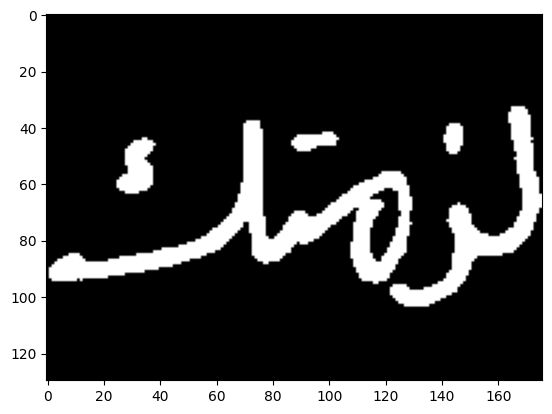

In [2]:
# Open the TIFF image
DATASET_IMAGES_PATH = "Dataset/Total Images/"
DATASET_LETTERS_PATH = "Dataset/Total GT/"

images = os.listdir(DATASET_IMAGES_PATH)

image_path = random.choice(images)

label_file = image_path.removesuffix(".tif")+".txt"
with open(os.path.join(DATASET_LETTERS_PATH, label_file), 'r') as lf:
    label = lf.read()

image = Image.open(os.path.join(DATASET_IMAGES_PATH, image_path))

# Display some basic information about the image
print("Dataset size:", len(images))
print("Image Format:", image.format)
print("Image Mode:", image.mode)
print("Image Size:", image.size)
print("Label: ", label)

image_array = np.array(image)

plt.imshow(image_array, cmap="gray");


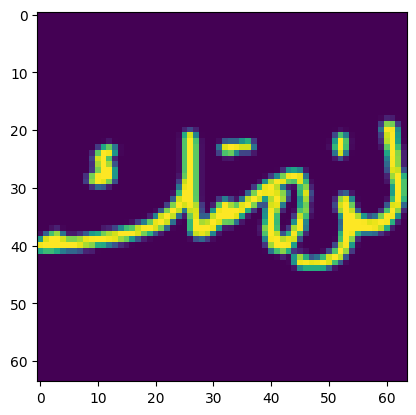

In [3]:
def find_size(numbers):
    first_non_zero_index = None
    last_non_zero_index = None

    for i, num in enumerate(numbers):
        if num != 0:
            if first_non_zero_index is None:
                first_non_zero_index = i
            last_non_zero_index = i

    # Check if any non-zero element found
    if first_non_zero_index is not None:
        size = last_non_zero_index - first_non_zero_index
    else:
        # If no non-zero elements found, set size to 0
        size = 0

    return {"start": first_non_zero_index,
            "end": last_non_zero_index,
            "size": size}


def square_crop(image, resize):
    # Find largest dimension vertical and horizontal
    v_dim = find_size(image.sum(axis=1))
    h_dim = find_size(image.sum(axis=0))
    
    # Create new image with largest dimension
    if h_dim["size"]>v_dim["size"]:
        cropped_image = torch.zeros(max(h_dim["size"]+1,28),max(h_dim["size"]+1,28))
    else:
        cropped_image = torch.zeros(max(v_dim["size"]+1,28),max(v_dim["size"]+1,28))

    # Cut the image and put it in the new cropped image then resize
    height, width = cropped_image.shape
    position_h = (height - v_dim["size"])//2, (height + v_dim["size"])//2
    position_w = (width - h_dim["size"])//2, (width + h_dim["size"])//2

    cropped_image[position_h[0]:position_h[1], position_w[0]:position_w[1]] = torch.Tensor(image[v_dim["start"]:v_dim["end"], h_dim["start"]:h_dim["end"]])
    cropped_image = resize(cropped_image[None,...])

    return cropped_image[0]

resize = torchvision.transforms.Resize((64,64))
cropped = square_crop(image_array, resize)
plt.imshow(cropped)

In [4]:
def get_unique_targets(labels_folder):
    unique_targets = set()

    for filename in os.listdir(labels_folder):
        label_path = os.path.join(labels_folder, filename)
        with open(label_path, 'r') as f:
            target = f.read()
            unique_targets.add(target.strip())

    return list(unique_targets)

def decode_target(id, unique_targets):
    return unique_targets[id]

In [6]:
import os
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Define the transformation to resize images to 28x28
resize = transforms.Resize((64,64))

class CustomDataset(Dataset):
    def __init__(self, images_folder, labels_folder, transform=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.image_names = os.listdir(images_folder)
        self.transform = transform
        self.unique_targets = get_unique_targets(labels_folder)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.images_folder, image_name)
        label_path = os.path.join(self.labels_folder, image_name.split(".")[0]+".txt")
        
        # Read the label
        with open(label_path, 'r') as f:
            label = f.read()

        # Read image using OpenCV
        image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply square crop and resize transformation
        image_tensor = square_crop(image_array, self.transform)
        
        # Normalize image pixel values
        image_tensor /= 255.0
        
        # Add channel dimension for grayscale image
        image_tensor = image_tensor.unsqueeze(0)

        return (image_tensor, self.unique_targets.index(label.strip()))

# Create an instance of CustomDataset
custom_dataset = CustomDataset(images_folder=DATASET_IMAGES_PATH,
                               labels_folder=DATASET_LETTERS_PATH,
                               transform=resize)

# Example usage of the custom dataset
for i in range(3):
    data = custom_dataset[i]
    print(data[0].shape)
    print(data[1])


torch.Size([1, 64, 64])
8
torch.Size([1, 64, 64])
163
torch.Size([1, 64, 64])
185


In [7]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Define the sizes for train, validation, and test sets
train_size = int(0.7 * len(custom_dataset))  # 70% of the data for training
val_size = int(0.15 * len(custom_dataset))   # 15% of the data for validation
test_size = len(custom_dataset) - train_size - val_size  # Remaining data for testing

# Use random_split to split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Example usage:
print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

# Define batch size for train, validation, and test DataLoader instances
batch_size_train = 32
batch_size_val = 32
batch_size_test = 32

# Create DataLoader instances for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# Example usage:
print("Number of batches in train loader:", len(train_loader))
print("Number of batches in validation loader:", len(val_loader))
print("Number of batches in test loader:", len(test_loader))


Train set size: 3611
Validation set size: 774
Test set size: 775
Number of batches in train loader: 113
Number of batches in validation loader: 25
Number of batches in test loader: 25


In [8]:
from datetime import datetime

def save_model_with_timestamp(model, folder_path="saved_models", suffix_format="%Y-%m-%d_%H-%M-%S"):
    """
    Saves the PyTorch model with a timestamp suffix to the specified folder.
    
    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        folder_path (str): The folder path where the model will be saved.
        suffix_format (str): The format of the timestamp suffix.
    """
    # Get the current date and time
    current_time = datetime.now().strftime(suffix_format)
    
    # Generate the file path with the timestamp suffix
    file_path = f"{folder_path}/{model.name}_{current_time}.pth"
    
    # Save the model
    torch.save(model, file_path)
    print(f"Model saved to {file_path}")

In [9]:
import torch.nn as nn

num_classes = len(custom_dataset.unique_targets)

# Step 1: Define model
from model_scripts import BenchmarkCnn, HandwritingRecognizer1, BenchmarkCnn2

# Step 2: Set up your training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BenchmarkCnn2(num_classes).to(device)
optimizer, lr_schedule = model.configure_optimizers()

criterion = nn.CrossEntropyLoss()

# Step 3: Train your model
num_epochs = 5

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        # print(model.features(data).shape)

        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


# Save the trained model
save_model_with_timestamp(model)

/home/idriss/github_repos/Arabic-Handwritten-OCR/.arabic-ocr/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x784 and 144x32)

Dataset size: 5160
Image Format: TIFF
Image Mode: L
Image Size: (33, 87)
Label:  ل
Predicted label:  


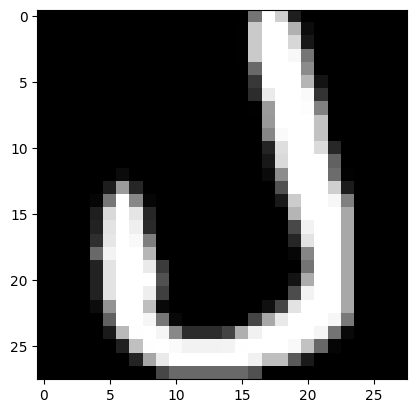

In [ ]:
def try_model(model,
              images_path=DATASET_IMAGES_PATH,
              labels_path=DATASET_LETTERS_PATH):

    images = os.listdir(DATASET_IMAGES_PATH)

    image_path = random.choice(images)

    label_file = image_path.removesuffix(".tif")+".txt"
    with open(os.path.join(DATASET_LETTERS_PATH, label_file), 'r') as lf:
        label = lf.read()

    image = Image.open(os.path.join(DATASET_IMAGES_PATH, image_path))

    # Display some basic information about the image
    print("Dataset size:", len(images))
    print("Image Format:", image.format)
    print("Image Mode:", image.mode)
    print("Image Size:", image.size)
    print("Label: ", label)

    image_array = square_crop(np.array(image),resize)

    x = torch.as_tensor(image_array).unsqueeze(0).unsqueeze(0).to(device)
    pred = torch.argmax(model(x))
    print("Predicted label: ", decode_target(pred, custom_dataset.unique_targets))

    plt.imshow(image_array, cmap="gray");

try_model(model)
